In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import stats
import math
pd.options.display.max_rows=200
import seaborn as sns

In [3]:
df_id_result = pd.read_csv('/data/210827_SJH_prosit/210916noPTM/search_result/massIVE-KB_result_noptm.tsv', sep='\t')
df_nid_result = pd.read_csv('/data/210827_SJH_prosit/210916noPTM/search_result/uniprot_result_noptm.tsv', sep='\t')

In [3]:
print(df_id_result.shape)
df_id_result.head(1)

(1165117, 17)


,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,Protein,DeNovoScore,MSGFScore,SpecEValue,EValue,QValue,PepQValue
0,massIVE-KB_predMS2_frac01_noptm.mgf,index=17911,-1,"17912 File:""massIVE-KB_predMS2_frac17912_noptm...",HCD,915.407,0,0.066675,4,NQSQGYNQWQQGQFWGQKPWSQHYHQGYY,"sp|Q00839|HNRPU_HUMAN(pre=K,post=-);tr|A0A1X7S...",264,264,2.147724e-42,5.912638e-35,0.0,0.0


In [4]:
print(df_nid_result.shape)
df_nid_result.head(1)

(1285166, 17)


,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,Protein,DeNovoScore,MSGFScore,SpecEValue,EValue,QValue,PepQValue
0,uniprot_predMS2_frac01_noptm.mgf,index=91556,-1,"91557 File:""uniprot_predMS2_frac91557_noptm.mg...",HCD,1791.814,0,0.0,2,NTFWDVDGSMVPPEWHRWLHSMTDDPPTTK,"sp|Q9UI09|NDUAC_HUMAN(pre=K,post=P)",340,340,3.764748e-42,1.041666e-34,0.0,0.0


* FDR control

In [6]:
def isDecoy(prot):
    prot_cnt = len(prot.split(';'))
    decoy_cnt = 0
    for p in prot.split(';'):
        if 'XXX' in p:
            decoy_cnt += 1
    if decoy_cnt == prot_cnt:
        return 'D'
    else:
        return 'T'

In [7]:
def getFDR(TD_list):
    start = time.time()
    
    FDR_list = []
    T_cnt = 0
    D_cnt = 0
    cut_idx = 0
    
    for idx, label in enumerate(TD_list):
        if label=='T':
            T_cnt += 1
        elif label == 'D':
            D_cnt += 1
        fdr = round((2*D_cnt) / (T_cnt + D_cnt), 2)
        if fdr <= 0.01:
            cut_idx = idx
    return cut_idx

In [8]:
def FDR_control(df, PERCENT):
    df_ = df.sort_values('EValue').reset_index(drop=True)  # copy
    df_['TD_label'] = df_.Protein.apply(isDecoy).values
    print('********** Target Decoy Labelling Done **********')
    cut_idx = getFDR(df_.TD_label.values)  
    print('********** Calculating FDR Done **********')
    df_ = df_.iloc[:cut_idx+1].reset_index(drop=True)
    df_ = df_.loc[df_.TD_label=='T'].reset_index(drop=True)
    return df_

In [9]:
df_id_target = FDR_control(df_id_result, 0.01)
df_nid_target = FDR_control(df_nid_result, 0.01)

print('massIVE-KB Evalue max, min : ', max(df_id_target.SpecEValue.values), min(df_id_target.SpecEValue.values))  # maaIVE-KB
print('uniprot Evalue max, min : ', max(df_nid_target.SpecEValue.values), min(df_nid_target.SpecEValue.values))  # uniprot

print('massIVE-KB Evalue max, min : ', max(df_id_target.EValue.values), min(df_id_target.EValue.values))  # maaIVE-KB
print('uniprot Evalue max, min : ', max(df_nid_target.EValue.values), min(df_nid_target.EValue.values))  # uniprot

********** Target Decoy Labelling Done **********
********** Calculating FDR Done **********
********** Target Decoy Labelling Done **********
********** Calculating FDR Done **********
massIVE-KB Evalue max, min :  3.6722186e-06 2.1477244403011e-42
uniprot Evalue max, min :  6.2978023e-09 1.4942184623296585e-44
massIVE-KB Evalue max, min :  96.76771 5.912637919438798e-35
uniprot Evalue max, min :  0.14632124 4.1343436498436185e-37


* decoy protien identificatin count

In [10]:
from matplotlib_venn import venn2, venn2_circles

nonDetection Peptide set : 2338
intersection cnt : 66
Detection Peptide set : 569
whole cnt : 2841



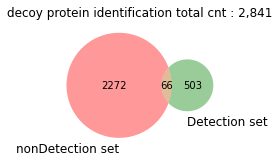

In [11]:
nid_proteins = {__.split('(')[0] for _ in df_nid_target.Protein.values for __ in _.split(';') if 'XXX' in __}
id_proteins = {__.split('(')[0] for _ in df_id_target.Protein.values for __ in _.split(';') if 'XXX' in __}

print('nonDetection Peptide set : {}\n\
intersection cnt : {}\n\
Detection Peptide set : {}\n\
whole cnt : {}\n'.format(len(nid_proteins),
         len(nid_proteins.intersection(id_proteins)),
         len(id_proteins),
         len(nid_proteins.union(id_proteins))))

plt.figure(figsize=(3, 3))
v = venn2(subsets=[nid_proteins, id_proteins], set_labels=('nonDetection set', 'Detection set'))
plt.title('decoy protein identification total cnt : {:,}'.format(len(nid_proteins.union(id_proteins))))
plt.show()

In [12]:
df_id_target_removeDecoy = df_id_target.copy()
df_nid_target_removeDecoy = df_nid_target.copy()

p = []
for prot in df_id_target_removeDecoy.Protein.values:
    p.append(';'.join([_ for _ in prot.split(';') if 'XXX' not in _]))
df_id_target_removeDecoy['Protein'] = p
df_id_target_removeDecoy = df_id_target_removeDecoy.loc[df_id_target_removeDecoy.Protein!='']
p = []
for prot in df_nid_target_removeDecoy.Protein.values:
    p.append(';'.join([_ for _ in prot.split(';') if 'XXX' not in _]))
df_nid_target_removeDecoy['Protein'] = p
df_nid_target_removeDecoy = df_nid_target_removeDecoy.loc[df_nid_target_removeDecoy.Protein!='']

In [13]:
unique_idx = np.where(df_id_target_removeDecoy.Protein.apply(lambda x: ';' not in x))[0]
shared_idx = np.where(df_id_target_removeDecoy.Protein.apply(lambda x: ';' in x))[0]
unique_cnt = len(df_id_target_removeDecoy.loc[unique_idx].Peptide.unique())
shared_cnt = len(df_id_target_removeDecoy.loc[shared_idx].Peptide.unique())
protein_nonMutate = {__.split('(')[0] for _ in df_id_target_removeDecoy.Protein.values for __ in _.split(';')}

print("총 PSM 수 :", len(df_id_target_removeDecoy))
print("펩타이드 수 :", len(df_id_target_removeDecoy.Peptide.unique()))
print('Unique 펩타이드 수 :', unique_cnt)
print('Shared 펩타이드 수 :', shared_cnt)
print('단백질 수 :', len(protein_nonMutate))

unique_idx = np.where(df_nid_target_removeDecoy.Protein.apply(lambda x: ';' not in x))[0]
shared_idx = np.where(df_nid_target_removeDecoy.Protein.apply(lambda x: ';' in x))[0]
unique_cnt = len(df_nid_target_removeDecoy.loc[unique_idx].Peptide.unique())
shared_cnt = len(df_nid_target_removeDecoy.loc[shared_idx].Peptide.unique())
protein_nonMutate = {__.split('(')[0] for _ in df_nid_target_removeDecoy.Protein.values for __ in _.split(';')}

print("\n총 PSM 수 :", len(df_nid_target_removeDecoy))
print("펩타이드 수 :", len(df_nid_target_removeDecoy.Peptide.unique()))
print('Unique 펩타이드 수 :', unique_cnt)
print('Shared 펩타이드 수 :', shared_cnt)
print('단백질 수 :', len(protein_nonMutate))

총 PSM 수 : 1164488
펩타이드 수 : 824043
Unique 펩타이드 수 : 354578
Shared 펩타이드 수 : 469465
단백질 수 : 65398

총 PSM 수 : 930814
펩타이드 수 : 926520
Unique 펩타이드 수 : 437270
Shared 펩타이드 수 : 489250
단백질 수 : 65139


* Protein identification count

In [14]:
nid_proteins = {__.split('(')[0] for _ in df_nid_target.Protein.values for __ in _.split(';') if 'XXX' not in __}
id_proteins = {__.split('(')[0] for _ in df_id_target.Protein.values for __ in _.split(';') if 'XXX' not in __}

print('nonDetection Peptide set : {}\n\
intersection cnt : {}\n\
Detection Peptide set : {}\n\
whole cnt : {}\n'.format(len(nid_proteins),
         len(nid_proteins.intersection(id_proteins)),
         len(id_proteins),
         len(nid_proteins.union(id_proteins))))

nonDetection Peptide set : 65139
intersection cnt : 62110
Detection Peptide set : 65398
whole cnt : 68427



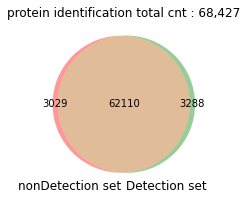

In [15]:
plt.figure(figsize=(3, 3))
v = venn2(subsets=[nid_proteins, id_proteins], set_labels=('nonDetection set', 'Detection set'))
plt.title('protein identification total cnt : {:,}'.format(len(nid_proteins.union(id_proteins))))
plt.show()

* Peptide idenfication count

In [16]:
id_precursors = {(k, v) for k, v in filter(lambda x: '+' not in x[0], df_id_target_removeDecoy[['Peptide', 'Charge']].values)}
nid_precursors = {(k, v) for k, v in filter(lambda x: '+' not in x[0], df_nid_target_removeDecoy[['Peptide', 'Charge']].values)}

print('nonDetection Peptide set : {:,}\n\
intersection cnt : {:,}\n\
Detection Peptide set : {:,}\n\
whole cnt : {:,}\n'.format(len(nid_precursors),
         len(nid_precursors.intersection(id_precursors)),
         len(id_precursors),
         len(nid_precursors.union(id_precursors))))

nonDetection Peptide set : 897,783
intersection cnt : 677
Detection Peptide set : 1,164,085
whole cnt : 2,061,191



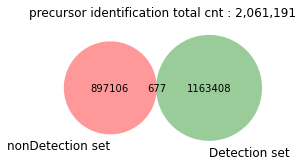

In [17]:
plt.figure(figsize=(4, 4))
v = venn2(subsets=[nid_precursors, id_precursors], set_labels=('nonDetection set', 'Detection set'))
plt.title('precursor identification total cnt : {:,}'.format(len(nid_precursors.union(id_precursors))))
plt.show()

nonDetection Peptide set : 897,783
intersection cnt : 943
Detection Peptide set : 823,957
whole cnt : 1,720,797



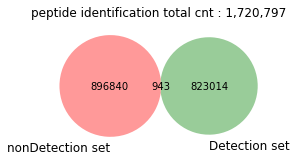

In [18]:
id_peptides = {k for k, v in filter(lambda x: '+' not in x[0], df_id_target_removeDecoy[['Peptide', 'Charge']].values)}
nid_peptides = {k for k, v in filter(lambda x: '+' not in x[0], df_nid_target_removeDecoy[['Peptide', 'Charge']].values)}

print('nonDetection Peptide set : {:,}\n\
intersection cnt : {:,}\n\
Detection Peptide set : {:,}\n\
whole cnt : {:,}\n'.format(len(nid_peptides),
         len(nid_peptides.intersection(id_peptides)),
         len(id_peptides),
         len(nid_peptides.union(id_peptides))))

plt.figure(figsize=(4, 4))
v = venn2(subsets=[nid_peptides, id_peptides], set_labels=('nonDetection set', 'Detection set'))
plt.title('peptide identification total cnt : {:,}'.format(len(nid_peptides.union(id_peptides))))
plt.show()

* MSGFscore violin plot

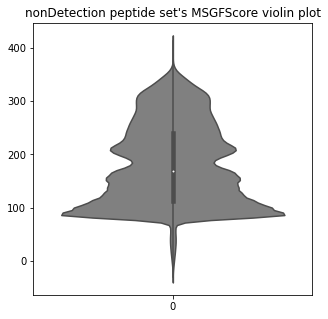

In [19]:
plt.figure(figsize=(5,5))
sns.violinplot(data=df_nid_target_removeDecoy.MSGFScore.values, color='gray')
plt.title('nonDetection peptide set\'s MSGFScore violin plot')
plt.show()

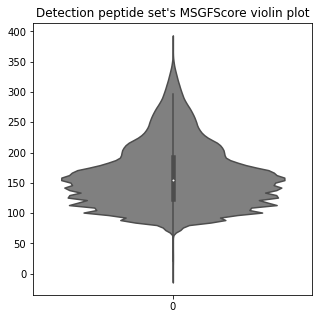

In [20]:
plt.figure(figsize=(5,5))
sns.violinplot(data=df_id_target_removeDecoy.MSGFScore.values, color='gray')
plt.title('Detection peptide set\'s MSGFScore violin plot')
plt.show()

In [21]:
df_nonid = pd.DataFrame([[_, 'nonID', 'score'] for _ in df_nid_target_removeDecoy.MSGFScore.values],
                        columns=['MSGFScore', 'label', 'score'])
df_id = pd.DataFrame([[_, 'ID', 'score'] for _ in df_id_target_removeDecoy.MSGFScore.values],
                     columns=['MSGFScore', 'label', 'score'])

df_MSGFScore = pd.concat([df_nonid, df_id], axis=0).reset_index(drop=True)

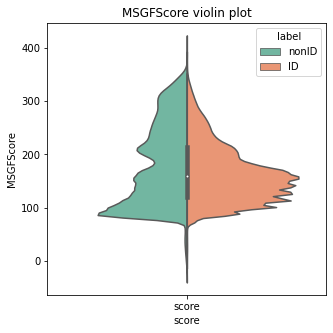

In [22]:
plt.figure(figsize=(5,5))
sns.violinplot(x='score', y="MSGFScore", hue="label",
                    data=df_MSGFScore, 
                    palette="Set2",
                    split=True,
                    scale="count"
                   )
plt.title('MSGFScore violin plot')
plt.show()

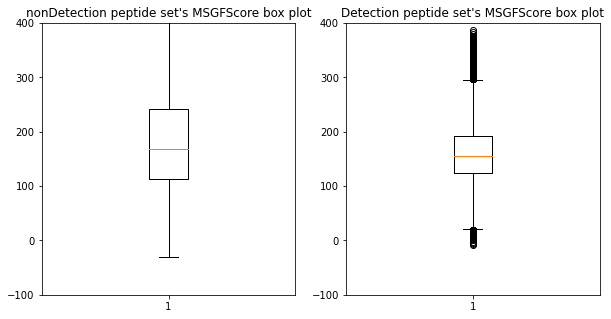

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10,5)
ax[0].boxplot(df_nid_target_removeDecoy.MSGFScore.values)
ax[1].boxplot(df_id_target_removeDecoy.MSGFScore.values)

ax[0].set_ylim(-100, 400)
ax[1].set_ylim(-100, 400)
ax[0].set_title('nonDetection peptide set\'s MSGFScore box plot')
ax[1].set_title('Detection peptide set\'s MSGFScore box plot')

plt.show()

# 2d plotting

In [24]:
%matplotlib inline

In [25]:
df_id_2d = pd.DataFrame([[len(p), m, 'ID', 'score'] for p, m in df_id_target[['Peptide', 'MSGFScore']].values],
                        columns=['PeptideLength', 'MSGFScore', 'Label', 'score'])
df_nonid_2d = pd.DataFrame([[len(p), m, 'nonID', 'score'] for p, m in df_nid_target[['Peptide', 'MSGFScore']].values],
                        columns=['PeptideLength', 'MSGFScore', 'Label', 'score'])

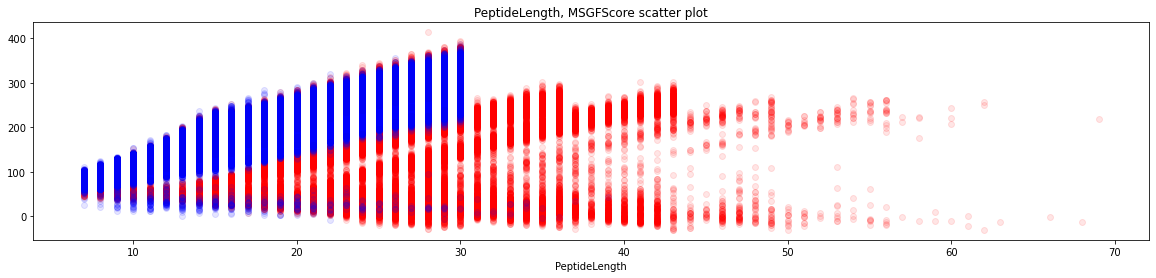

In [26]:
plt.figure(figsize=(20,4))

p = df_nonid_2d.sort_values('PeptideLength').PeptideLength.values
m = df_nonid_2d.sort_values('PeptideLength').MSGFScore.values
plt.scatter(p, m, alpha = 0.1, color='red', label='nonID')

p = df_id_2d.sort_values('PeptideLength').PeptideLength.values
m = df_id_2d.sort_values('PeptideLength').MSGFScore.values
plt.scatter(p, m, alpha = 0.1, color='blue', label='ID')

plt.title('PeptideLength, MSGFScore scatter plot')
plt.xlabel('PeptideLength')
plt.show()

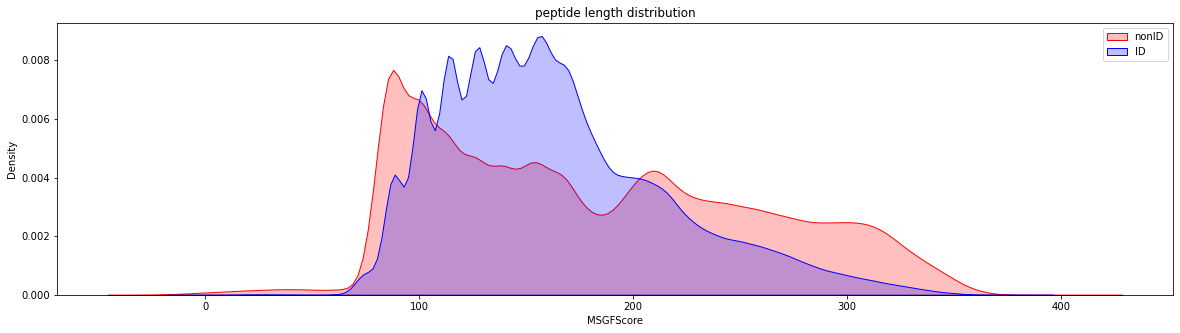

In [27]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d.MSGFScore, shade=True, color='red')

sns.kdeplot(df_id_2d.MSGFScore, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('peptide length distribution')
plt.show()

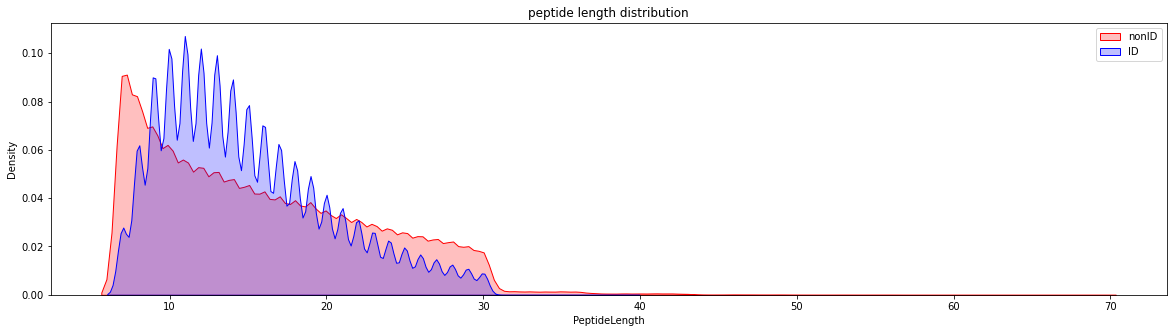

In [28]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d.PeptideLength, shade=True, color='red')

sns.kdeplot(df_id_2d.PeptideLength, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('peptide length distribution')
plt.show()

# 3d plotting

In [29]:
print('id min max : ', min(df_id_2d.MSGFScore.values), max(df_id_2d.MSGFScore.values), 
      '\nnid min max : ', min(df_nonid_2d.MSGFScore.values), max(df_nonid_2d.MSGFScore.values))
max_val = max(max(df_id_2d.MSGFScore.values), max(df_nonid_2d.MSGFScore.values))
min_val = min(min(df_id_2d.MSGFScore.values), min(df_nonid_2d.MSGFScore.values))

id min max :  -8 387 
nid min max :  -31 414


In [30]:
lenscore2freq = dict()
for p, m in df_id_2d[['PeptideLength', 'MSGFScore']].values:
    if p <= 30:  # only use under peptide length 30
        if (p,m) not in lenscore2freq:
            lenscore2freq[(p,m)]=0
        lenscore2freq[(p, m)] += 1
df_id_3d = pd.DataFrame([[p, m, f, 'ID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'MSGFScore', 'Frequency', 'Label'])

lenscore2freq = dict()
for p, m in df_nonid_2d[['PeptideLength', 'MSGFScore']].values:
    if p <= 30:
        if (p,m) not in lenscore2freq:
            lenscore2freq[(p,m)]=0
        lenscore2freq[(p, m)] += 1
df_nonid_3d = pd.DataFrame([[p, m, f, 'nonID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'MSGFScore', 'Frequency', 'Label'])

In [31]:
%matplotlib notebook

<IPython.core.display.Javascript object>


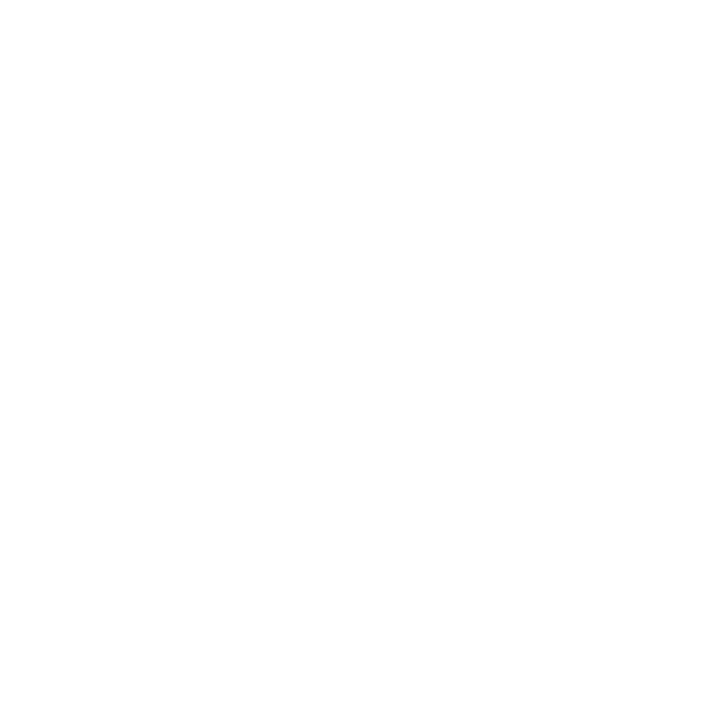

In [32]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d.PeptideLength.values
y = df_nonid_3d.MSGFScore.values
z = df_nonid_3d.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d.PeptideLength.values
y2 = df_id_3d.MSGFScore.values
z2 = df_id_3d.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

ax.set_xlabel('Peptide Length')
ax.set_ylabel('MSGF score')
ax.set_zlabel('Frequency')
plt.show()

<IPython.core.display.Javascript object>


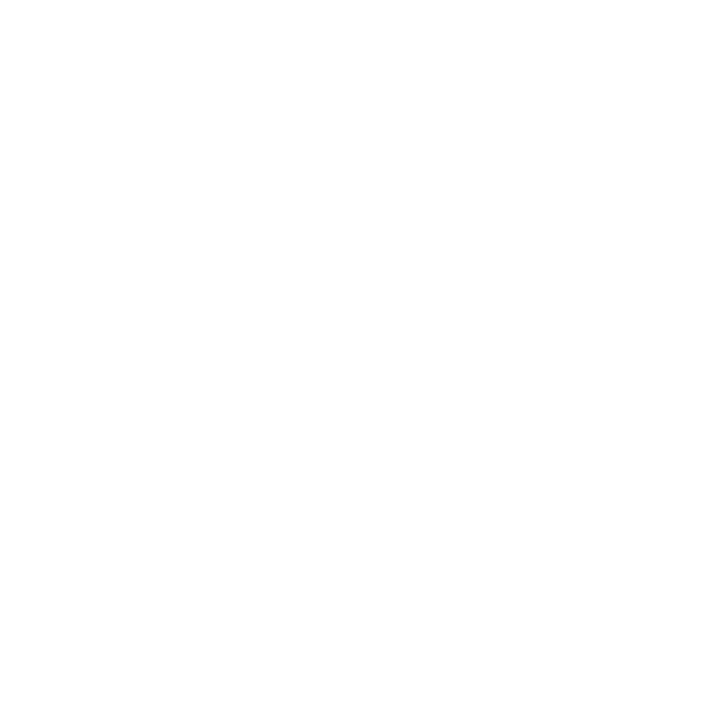

In [33]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d.PeptideLength.values
y = df_nonid_3d.MSGFScore.values
z = df_nonid_3d.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d.PeptideLength.values
y2 = df_id_3d.MSGFScore.values
z2 = df_id_3d.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

ax.set_xlabel('Peptide Length')
ax.set_ylabel('MSGF score')
ax.set_zlabel('Frequency')
plt.show()

In [34]:
df_id_3d_cut = df_id_3d.loc[df_id_3d.Frequency<=4000]
df_nonid_3d_cut = df_nonid_3d.loc[df_nonid_3d.Frequency<=4000]

<IPython.core.display.Javascript object>


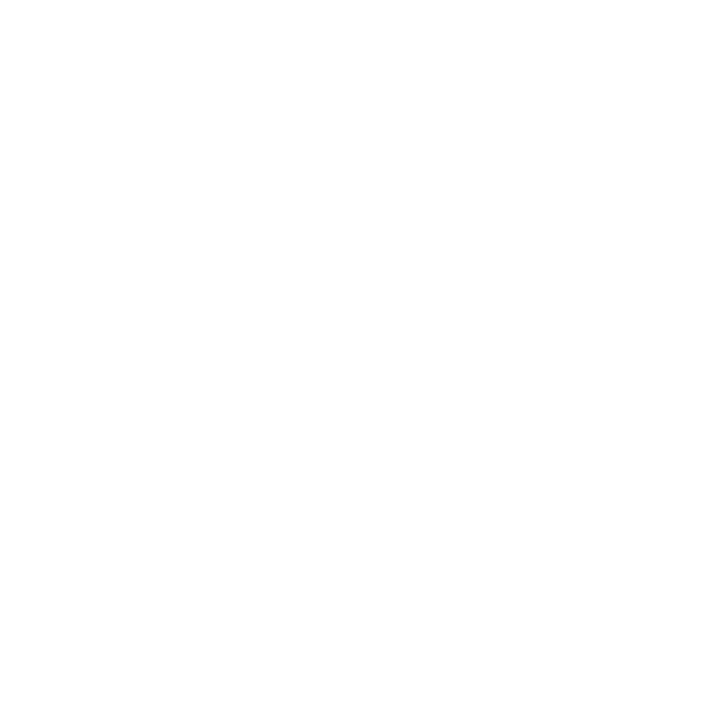

In [35]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d_cut.PeptideLength.values
y = df_nonid_3d_cut.MSGFScore.values
z = df_nonid_3d_cut.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d_cut.PeptideLength.values
y2 = df_id_3d_cut.MSGFScore.values
z2 = df_id_3d_cut.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

ax.set_xlabel('Peptide Length')
ax.set_ylabel('MSGF score')
ax.set_zlabel('Frequency')
plt.show()

# not FDR (whole PSM plotting)

# 2d plotting

In [36]:
%matplotlib inline

In [9]:
df_id_result['TD'] = df_id_result.Protein.apply(isDecoy).values
df_nid_result['TD'] = df_nid_result.Protein.apply(isDecoy).values

df_id_target_whole = df_id_result.loc[df_id_result.TD=='T'].reset_index(drop=True)
df_nid_target_whole = df_nid_result.loc[df_nid_result.TD=='T'].reset_index(drop=True)

In [30]:
df_id_2d_nofdr = pd.DataFrame([[len(p), m, se, e, 'ID', 'score'] 
                               for p, m, se, e in df_id_target_whole[['Peptide', 'MSGFScore', 'SpecEValue', 'EValue']].values],
                        columns=['PeptideLength', 'MSGFScore', 'SpecEValue', 'EValue', 'Label', 'score'])
df_nonid_2d_nofdr = pd.DataFrame([[len(p), m, se, e, 'nonID', 'score'] 
                               for p, m, se, e in df_nid_target_whole[['Peptide', 'MSGFScore', 'SpecEValue', 'EValue']].values],
                        columns=['PeptideLength', 'MSGFScore', 'SpecEValue', 'EValue', 'Label', 'score'])

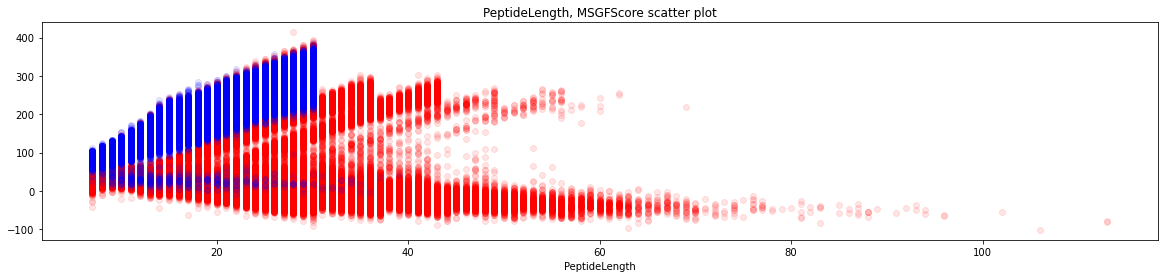

In [31]:
plt.figure(figsize=(20,4))

p = df_nonid_2d_nofdr.sort_values('PeptideLength').PeptideLength.values
m = df_nonid_2d_nofdr.sort_values('PeptideLength').MSGFScore.values
plt.scatter(p, m, alpha = 0.1, color='red', label='nonID')

p = df_id_2d_nofdr.sort_values('PeptideLength').PeptideLength.values
m = df_id_2d_nofdr.sort_values('PeptideLength').MSGFScore.values
plt.scatter(p, m, alpha = 0.1, color='blue', label='ID')

plt.title('PeptideLength, MSGFScore scatter plot')
plt.xlabel('PeptideLength')
plt.show()

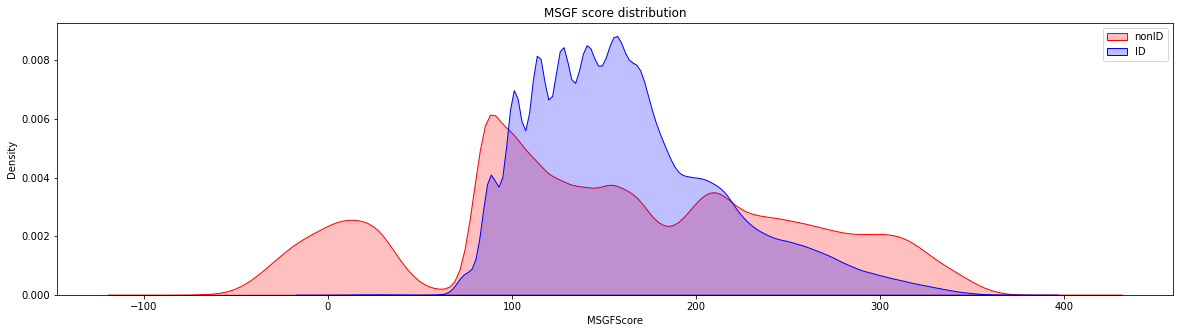

In [32]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d_nofdr.MSGFScore, shade=True, color='red')

sns.kdeplot(df_id_2d_nofdr.MSGFScore, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('MSGF score distribution')
plt.show()

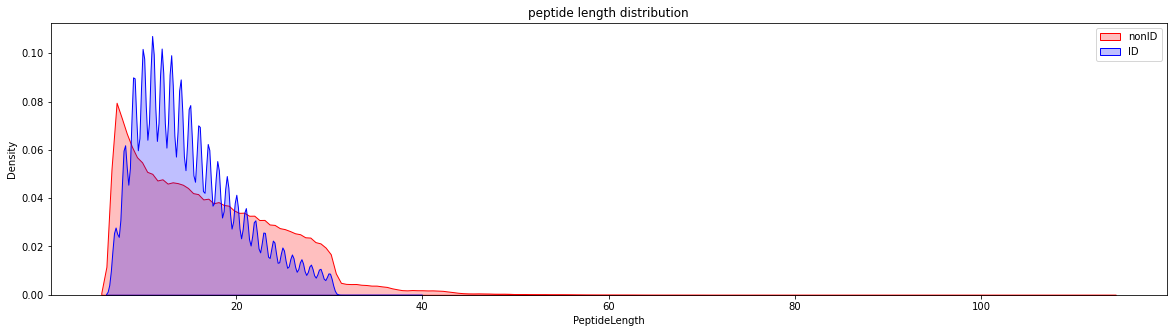

In [33]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d_nofdr.PeptideLength, shade=True, color='red')

sns.kdeplot(df_id_2d_nofdr.PeptideLength, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('peptide length distribution')
plt.show()

- Evalue score

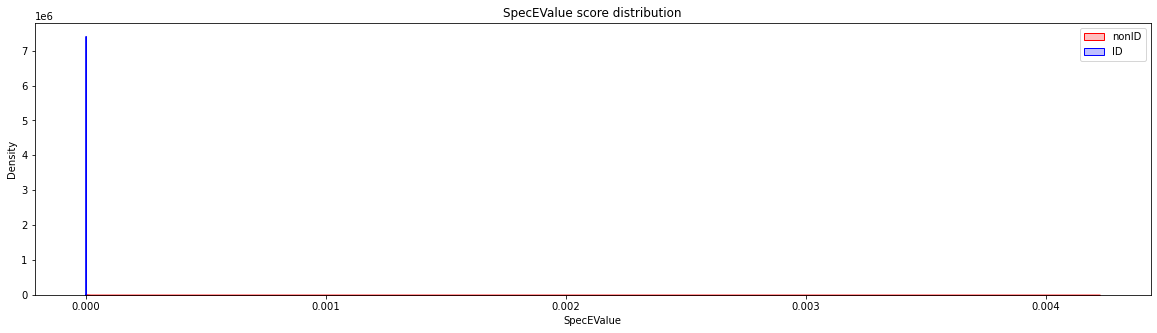

In [51]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d_nofdr.SpecEValue, shade=True, color='red')

sns.kdeplot(df_id_2d_nofdr.SpecEValue, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('SpecEValue score distribution')
plt.show()

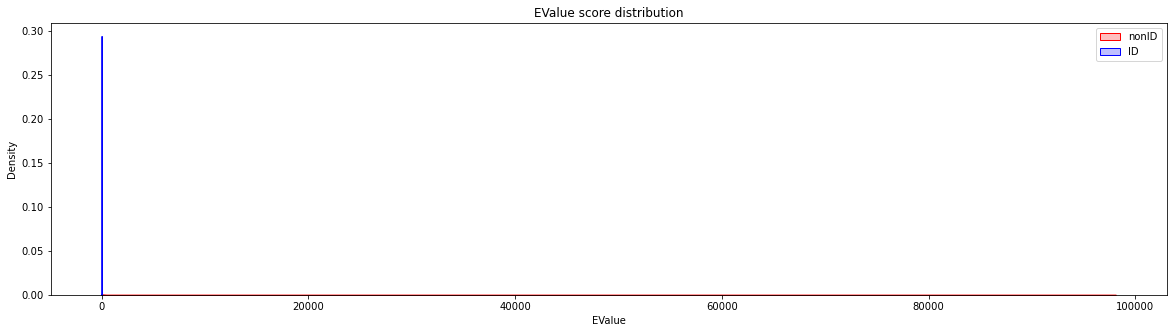

In [54]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_nonid_2d_nofdr.EValue, shade=True, color='red')

sns.kdeplot(df_id_2d_nofdr.EValue, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('EValue score distribution')
plt.show()

* log scale로 분포 확인하기

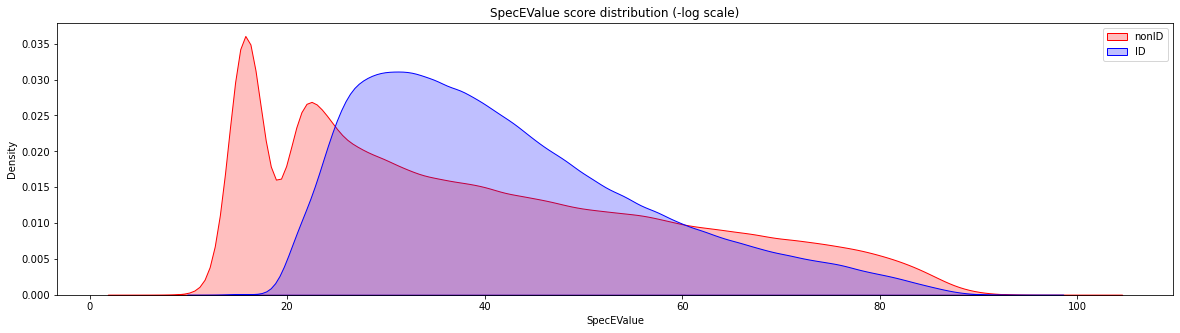

In [34]:
nl = df_nonid_2d_nofdr.SpecEValue.apply(lambda x: -math.log(x))
pl = df_id_2d_nofdr.SpecEValue.apply(lambda x: -math.log(x))

plt.figure(figsize=(20,5))
sns.kdeplot(nl, shade=True, color='red')

sns.kdeplot(pl, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('SpecEValue score distribution (-log scale)')
plt.show()

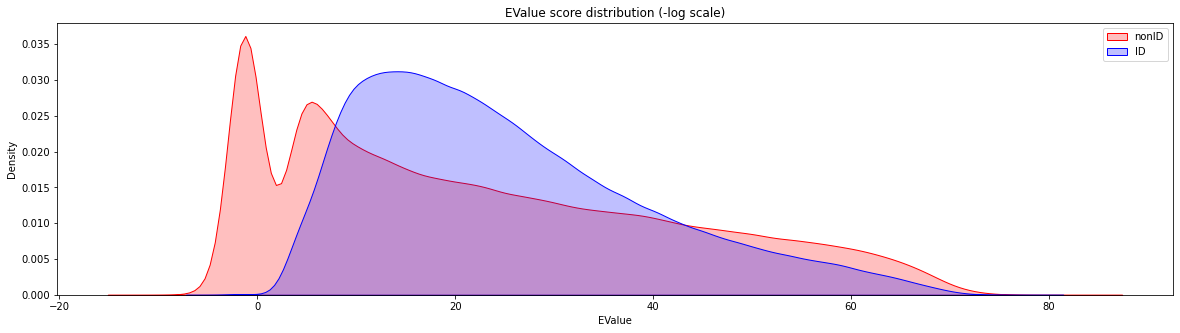

In [35]:
nl = df_nonid_2d_nofdr.EValue.apply(lambda x: -math.log(x))
pl = df_id_2d_nofdr.EValue.apply(lambda x: -math.log(x))

plt.figure(figsize=(20,5))
sns.kdeplot(nl, shade=True, color='red')

sns.kdeplot(pl, shade=True, color='blue')
plt.legend(['nonID', 'ID'])
plt.title('EValue score distribution (-log scale)')
plt.show()

# 3d plotting

In [62]:
print('id min max : ', min(df_id_2d_nofdr.MSGFScore.values), max(df_id_2d_nofdr.MSGFScore.values), 
      '\nnid min max : ', min(df_nonid_2d_nofdr.MSGFScore.values), max(df_nonid_2d_nofdr.MSGFScore.values))
max_val = max(max(df_id_2d_nofdr.MSGFScore.values), max(df_nonid_2d_nofdr.MSGFScore.values))
min_val = min(min(df_id_2d_nofdr.MSGFScore.values), min(df_nonid_2d_nofdr.MSGFScore.values))

id min max :  -8 387 
nid min max :  -102 414


In [63]:
lenscore2freq = dict()
for p, m in df_id_2d_nofdr[['PeptideLength', 'MSGFScore']].values:
    if p <= 30:  # only use under peptide length 30
        if (p,m) not in lenscore2freq:
            lenscore2freq[(p,m)]=0
        lenscore2freq[(p, m)] += 1
df_id_3d_nofdr = pd.DataFrame([[p, m, f, 'ID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'MSGFScore', 'Frequency', 'Label'])

lenscore2freq = dict()
for p, m in df_nonid_2d_nofdr[['PeptideLength', 'MSGFScore']].values:
    if p <= 30:
        if (p,m) not in lenscore2freq:
            lenscore2freq[(p,m)]=0
        lenscore2freq[(p, m)] += 1
df_nonid_3d_nofdr = pd.DataFrame([[p, m, f, 'nonID'] for (p, m), f in lenscore2freq.items()],
                              columns=['PeptideLength', 'MSGFScore', 'Frequency', 'Label'])

In [64]:
%matplotlib notebook

<IPython.core.display.Javascript object>


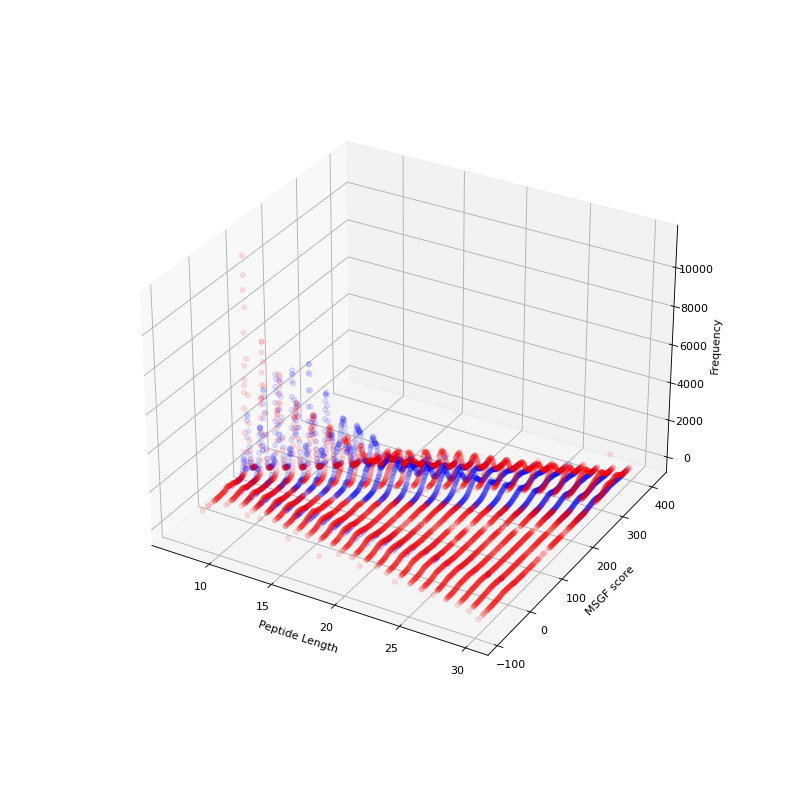

In [65]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d_nofdr.PeptideLength.values
y = df_nonid_3d_nofdr.MSGFScore.values
z = df_nonid_3d_nofdr.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d_nofdr.PeptideLength.values
y2 = df_id_3d_nofdr.MSGFScore.values
z2 = df_id_3d_nofdr.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

ax.set_xlabel('Peptide Length')
ax.set_ylabel('MSGF score')
ax.set_zlabel('Frequency')
plt.show()

In [66]:
df_id_3d_nofdr_cut = df_id_3d_nofdr.loc[df_id_3d_nofdr.Frequency<=4000]
df_nonid_3d_nofdr_cut = df_nonid_3d_nofdr.loc[df_nonid_3d_nofdr.Frequency<=4000]

<IPython.core.display.Javascript object>


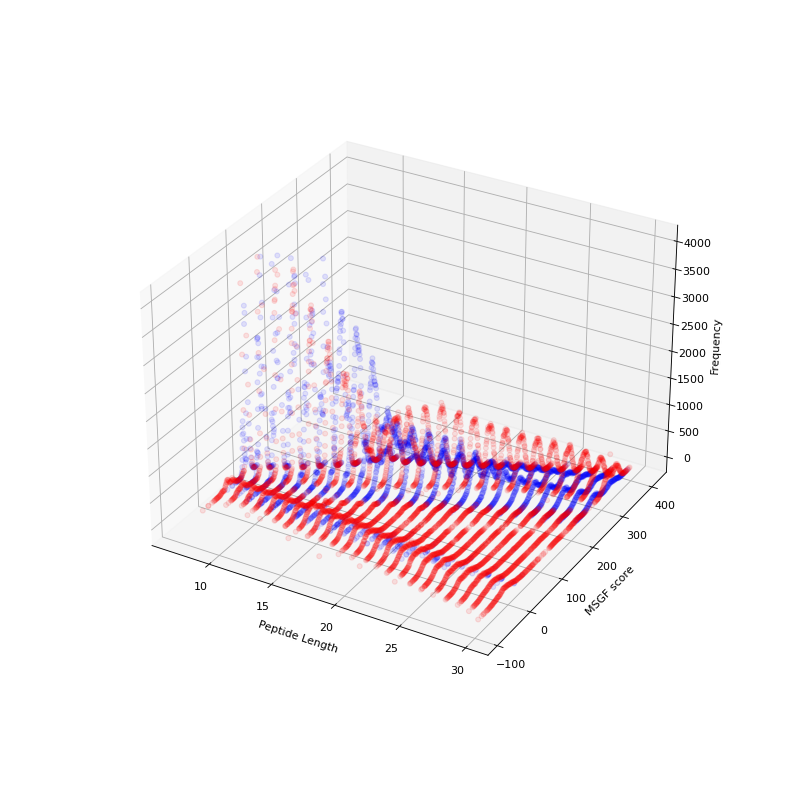

In [67]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = df_nonid_3d_nofdr_cut.PeptideLength.values
y = df_nonid_3d_nofdr_cut.MSGFScore.values
z = df_nonid_3d_nofdr_cut.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='red')
x2 = df_id_3d_nofdr_cut.PeptideLength.values
y2 = df_id_3d_nofdr_cut.MSGFScore.values
z2 = df_id_3d_nofdr_cut.Frequency.values
ax.scatter(x2, y2, z2, alpha = 0.1, color='blue')

ax.set_xlabel('Peptide Length')
ax.set_ylabel('MSGF score')
ax.set_zlabel('Frequency')
plt.show()

# MSGF zero peptide vs FDR 1% peptide

* get zero unDetected peptide

In [36]:
df_nid_target_whole.head()

,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,Protein,DeNovoScore,MSGFScore,SpecEValue,EValue,QValue,PepQValue,TD
0,uniprot_predMS2_frac01_noptm.mgf,index=91556,-1,"91557 File:""uniprot_predMS2_frac91557_noptm.mg...",HCD,1791.8140,0,0.0,2,NTFWDVDGSMVPPEWHRWLHSMTDDPPTTK,"sp|Q9UI09|NDUAC_HUMAN(pre=K,post=P)",340,340,3.764748e-42,1.041666e-34,0.0,0.0,T
1,uniprot_predMS2_frac01_noptm.mgf,index=63831,-1,"63832 File:""uniprot_predMS2_frac63832_noptm.mg...",HCD,1924.9176,0,0.0,2,RKLDTGQYQEPWQYVDDVWLMFNNAWLYNR,"sp|Q92793|CBP_HUMAN(pre=K,post=K);tr|I3L466|I3...",311,307,5.601728e-42,1.549939e-34,0.0,0.0,T
2,uniprot_predMS2_frac01_noptm.mgf,index=86396,-1,"86397 File:""uniprot_predMS2_frac86397_noptm.mg...",HCD,1859.3660,0,0.0,2,YESEWTNEVSMVLTGAAFYHKYFNYLYTYK,"sp|Q93063|EXT2_HUMAN(pre=K,post=M)",355,355,1.301156e-41,3.600160e-34,0.0,0.0,T
3,uniprot_predMS2_frac01_noptm.mgf,index=48165,-1,"48166 File:""uniprot_predMS2_frac48166_noptm.mg...",HCD,1770.3354,0,0.0,2,SSRHHHTDGAYFGTGFPHMLFMVHPEYRPK,"sp|P67870|CSK2B_HUMAN(pre=K,post=R);tr|Q5SRQ6|...",310,303,1.904276e-41,5.268929e-34,0.0,0.0,T
4,uniprot_predMS2_frac01_noptm.mgf,index=83407,-1,"83408 File:""uniprot_predMS2_frac83408_noptm.mg...",HCD,1727.2976,0,0.0,2,VQVSMTTANVSWEPGYDGGYEQTFSVWMKR,"sp|Q9UPX0|TUTLB_HUMAN(pre=R,post=A)",351,351,2.067429e-41,5.720357e-34,0.0,0.0,T


In [39]:
# check lowest score

under80 = sorted(list(filter(lambda x: x<=80 and x >= 0, df_nid_target_whole.MSGFScore)), reverse=True)
under80_cnt = dict()
for _ in under80:
    if _ not in under80_cnt:
        under80_cnt[_]=0
    under80_cnt[_]+=1
print('lowest score, freq : ', sorted(under80_cnt.items(), key=lambda x: x[1], )[0])

lowest score, freq :  (68, 149)


In [10]:
# check lowest score
df_nid_target_whole['logSpecEValue'] = df_nid_target_whole.SpecEValue.apply(lambda x: -math.log(x))
df_nid_target_whole['logEValue'] = df_nid_target_whole.EValue.apply(lambda x: -math.log(x))

In [250]:
under80 = sorted(list(filter(lambda x: x<=10 and x >= 0, df_nid_target_whole.logEValue)), reverse=True)
under80_cnt = dict()
for _ in under80:
    _ = round(_, 2)
    if _ not in under80_cnt:
        under80_cnt[_]=0
    under80_cnt[_]+=1
print('lowest score, freq : ', sorted(under80_cnt.items(), key=lambda x: x[1], )[0])

lowest score, freq :  (1.99, 58)


In [249]:
# check lowest score

under80 = sorted(list(filter(lambda x: x<=25 and x >= 15, df_nid_target_whole.logSpecEValue)), reverse=True)
under80_cnt = dict()
for _ in under80:
    _ = round(_, 2)
    if _ not in under80_cnt:
        under80_cnt[_]=0
    under80_cnt[_]+=1

print('lowest score, freq : ', sorted(under80_cnt.items(), key=lambda x: x[1], )[0])

lowest score, freq :  (19.5, 57)


In [254]:
df_zero = df_nid_target_whole.loc[df_nid_target_whole.MSGFScore<=68]

pep_zero_ptm = set()
pep_zero_noptm = set()
for p in df_zero.Peptide.values:
    if '+' in p:
        pep_zero_ptm.add(p)
    else:
        pep_zero_noptm.add(p)

pep_zero = df_zero.Peptide.unique()

print('total zero MSGF score peptides : {:,}'.format(len(pep_zero)))
print('zero MSGF score ptm_peptides : {:,}'.format(len(pep_zero_ptm)))
print('zero MSGF score noptm_peptides : {:,}'.format(len(pep_zero_noptm)))

total zero MSGF score peptides : 183,012
zero MSGF score ptm_peptides : 89,470
zero MSGF score noptm_peptides : 93,542


In [255]:
df_zero = df_nid_target_whole.loc[df_nid_target_whole.logSpecEValue<=19.5]

pep_zero_ptm = set()
pep_zero_noptm = set()
for p in df_zero.Peptide.values:
    if '+' in p:
        pep_zero_ptm.add(p)
    else:
        pep_zero_noptm.add(p)

pep_zero = df_zero.Peptide.unique()

print('total zero MSGF score peptides : {:,}'.format(len(pep_zero)))
print('zero MSGF score ptm_peptides : {:,}'.format(len(pep_zero_ptm)))
print('zero MSGF score noptm_peptides : {:,}'.format(len(pep_zero_noptm)))

total zero MSGF score peptides : 178,981
zero MSGF score ptm_peptides : 84,394
zero MSGF score noptm_peptides : 94,587


In [256]:
df_zero = df_nid_target_whole.loc[df_nid_target_whole.logEValue<=1.99]

pep_zero_ptm = set()
pep_zero_noptm = set()
for p in df_zero.Peptide.values:
    if '+' in p:
        pep_zero_ptm.add(p)
    else:
        pep_zero_noptm.add(p)

pep_zero = df_zero.Peptide.unique()

print('total zero MSGF score peptides : {:,}'.format(len(pep_zero)))
print('zero MSGF score ptm_peptides : {:,}'.format(len(pep_zero_ptm)))
print('zero MSGF score noptm_peptides : {:,}'.format(len(pep_zero_noptm)))

total zero MSGF score peptides : 174,291
zero MSGF score ptm_peptides : 83,107
zero MSGF score noptm_peptides : 91,184


In [71]:
import pickle
with open('pep_zeroMSGF_noptm.pickle', 'wb') as f:
    pickle.dump(pep_noptm, f, pickle.HIGHEST_PROTOCOL)

# with open('pep_zeroMSGF_noptm.pickle', 'rb') as f:
#     t = pickle.load(f)

* 실제 정답과 Target이 얼마나 교집합인지 확인

In [42]:
df_nid_real = pd.read_csv('../data/uniprot/df_whole_pep_from_prot_noptm.csv')
nid_pep = set(df_nid_real.loc[df_nid_real.ID==0].PEP.unique())  # theoretical peptides
nid_pep_pred = set(df_nid_target_whole.Peptide.unique())  # MSGF search result's peptides

df_id_real = pd.read_csv('../data/massIVE-KB/df_kb_noptm.csv')
id_pep = set(df_id_real.PEPTIDE.unique())  # massIVE-KB's ided peptides
id_pep_pred = set(df_id_target_whole.Peptide.unique())  # MSGF search result's peptides

In [77]:
print('nid peptide total cnt : {:,}\nid peptide total cnt : {:,}'.format(len(nid_pep), len(id_pep)))

nid peptide total cnt : 1,420,194
id peptide total cnt : 823,730


In [46]:
id_common = id_pep.intersection(id_pep_pred)
nid_common = nid_pep.intersection(nid_pep_pred)
print('id : correct / whole_target:{:,} / {:,}\nnid : correct / whole_target:{:,} / {:,}'.format(
    len(id_common), len(id_pep_pred), len(nid_common), len(nid_pep_pred)))

id : correct / whole_target:823,038 / 824,043
nid : correct / whole_target:897,192 / 1,084,942


In [53]:
zero_pep_pred = set(pep_zero)
zeroMSGF_common = nid_pep.intersection(zero_pep_pred)
print('near zero MSGF score nid : correct / whole_target:{:,} / {:,}'.format(len(zeroMSGF_common), len(zero_pep_pred)))

near zero MSGF score nid : correct / whole_target:17,239 / 183,012


In [78]:
zero_pep_pred = set(pep_zero)
zeroMSGF_common = id_pep.intersection(zero_pep_pred)
print('near zero MSGF score nid : correct with id / whole_target:{:,} / {:,}'.format(len(zeroMSGF_common), len(zero_pep_pred)))

near zero MSGF score nid : correct / whole_target:9,618 / 183,012


In [58]:
df_upzero = df_nid_target_whole.loc[df_nid_target_whole.MSGFScore > 68]

pep_ptm = set()
pep_noptm = set()
for p in df_upzero.Peptide.values:
    if '+' in p:
        pep_ptm.add(p)
    else:
        pep_noptm.add(p)
zeroup_pep_pred = set(df_upzero.Peptide.unique())

print('total zero MSGF score peptides : {:,}'.format(len(zeroup_pep_pred)))
print('zero MSGF score ptm_peptides : {:,}'.format(len(pep_ptm)))
print('zero MSGF score noptm_peptides : {:,}'.format(len(pep_noptm)))

total zero MSGF score peptides : 917,408
zero MSGF score ptm_peptides : 21,833
zero MSGF score noptm_peptides : 895,575


In [60]:
zeroupMSGF_common = nid_pep.intersection(zeroup_pep_pred)
print('up zero MSGF score nid : correct / whole_target:{:,} / {:,}'.format(len(zeroupMSGF_common), len(zeroup_pep_pred)))

up zero MSGF score nid : correct / whole_target:895,093 / 917,408


In [102]:
# 그럼 result seqeucne는 fully tryptic이 아닌가?
def make_fullyTrypticPeptide(df_uni, MISS_CLEAVAGE):
    peptide = []
    TS_AA = 'KR'
    
    for protein in df_uni.SEQUENCE.values:
        ts_idx = []  # tryptic site index
        for prot_idx, aa in enumerate(protein):
            if aa in TS_AA:
                ts_idx.append(prot_idx)
        for idx in range(len(ts_idx)):
            n = MISS_CLEAVAGE
            if idx+(n+1) > len(ts_idx)-1:  # peptide making range
                break
            # peptide
            if ts_idx[idx+n+1] == len(protein)-1:  # protein C term = idx + n + 1 의 tryptic_site 가 단백질의 마지막인 경우
                pep = protein[ts_idx[idx]] + '.' + protein[ts_idx[idx]+1:ts_idx[idx+n+1]+1] + '.-'
            else:
                pep = protein[ts_idx[idx]] + '.' + protein[ts_idx[idx]+1:ts_idx[idx+n+1]+1] + '.' + protein[ts_idx[idx+n+1]+1]
            peptide.append(pep)
    return peptide

df_uni = pd.read_csv('../data/uniprot/df_uni_noptm_ided.csv')

peptide0 = make_fullyTrypticPeptide(df_uni, 0)
peptide1 = make_fullyTrypticPeptide(df_uni, 1)
peptide2 = make_fullyTrypticPeptide(df_uni, 2)
# peptide3 = make_fullyTrypticPeptide(df_uni, 3)
# peptide4 = make_fullyTrypticPeptide(df_uni, 4)

peptide = list(set(peptide0).union(set(peptide1)).union(set(peptide2)).union(set(peptide3)).union(set(peptide4)))

# import sys
# sys.path.append('/home/bis/2021_SJH_detectability/Detectability/')

from utils import *

trie = Trie()
for p in [i.split('.')[1] for i in peptide]:
    trie.insert(p)

fully_tryptic = [pep for pep in pep_zero_noptm if trie.search(pep)==True]

STRIP_PEP = pep_zero_noptm
STRIP_PEP_cnt = len(STRIP_PEP)
fULLY_PEP = set(fully_tryptic)
fULLY_PEP_cnt = len(fULLY_PEP)
SEMI_PEP = STRIP_PEP.difference(fULLY_PEP)
SEMI_PEP_cnt = STRIP_PEP_cnt-fULLY_PEP_cnt

fully tryptic cnt : 35,425


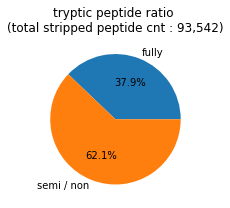

In [257]:
# ided uniprot
print('fully tryptic cnt : {:,}'.format(len(fully_tryptic)))
plt.figure(figsize=(3,3))
plt.pie([fULLY_PEP_cnt, SEMI_PEP_cnt], labels=['fully', 'semi / non'], autopct='%1.1f%%')
plt.title('tryptic peptide ratio \n(total stripped peptide cnt : {:,})'.format(STRIP_PEP_cnt))
plt.show()

In [258]:
# MSGF search된 Bad Spectrum( MSGF score 0 )의 result sequence는 딥러닝데이터셋에 있을까?
test = pd.read_csv('../data/df_detect_peptide_test_noptm_211018_includeDigest.csv')
train = pd.read_csv('../data/df_detect_peptide_train_noptm_211018_includeDigest.csv')
df_dl = pd.concat([train, test], axis=0).reset_index(drop=True)
dl_pep = set(df_dl.PEP.unique())
dl_common = dl_pep.intersection(pep_zero_noptm)
print(len(dl_common))

7329


In [259]:
df_key = pd.DataFrame([[_, True] for _ in dl_common], columns=['PEP', 'DROP'])
df_dl.merge(df_key, on='PEP').drop('DROP', axis=1).to_csv('211018MS2problem_possibility.csv', index=False)

# MSGF zero spectrum vs FDR 1% spectrum
  - 예측된 스펙트럼에 차이가 있는지 찾아보기
  - 일단 peak ratio, peak count (intensitiy>=0.01)
  - 그리고 EDA해보고 추가적으로 생각해보기

In [1]:
import pickle

with open('../data/massIVE-KB/211018_notpm_pep2spec_pred.pickle', 'rb') as f:
    pep2spec_pred = pickle.load(f)
with open('../data/uniprot/211018_notpm_npep2spec_pred.pickle', 'rb') as f:
    npep2spec_pred = pickle.load(f)

In [125]:
print(len(pep2spec_pred), len(npep2spec_pred))

(1163969, 1252661)

In [11]:
df_nid_target_whole['KEY'] = df_nid_target_whole.Title.apply(lambda x: x.split()[0]).values
df_id_target_whole['KEY'] = df_id_target_whole.Title.apply(lambda x: x.split()[0]).values

In [147]:
print(len(df_id_target_whole.KEY.unique()), len(df_nid_target_whole.KEY.unique()))

1096213 1163565


In [15]:
df_id_key = pd.DataFrame([[str(_+1), 
                           ';'.join(list(map(str, dic.keys()))),
                           ';'.join(list(map(str, dic.values()))),
                           p,
                           c,
                           True] for _, ((p, c), dic) in enumerate(pep2spec_pred.items())],
                         columns=['KEY', 'MZ', 'INT', 'PEP', 'CHA', 'DROP'])
df_nid_key = pd.DataFrame([[str(_+1), 
                           ';'.join(list(map(str, dic.keys()))),
                           ';'.join(list(map(str, dic.values()))),
                           p,
                           c,
                           True] for _, ((p, c), dic) in enumerate(npep2spec_pred.items())],
                         columns=['KEY', 'MZ', 'INT', 'PEP', 'CHA', 'DROP'])

df_nid_spec = df_nid_target_whole.merge(df_nid_key, on='KEY', how='left').drop('DROP', axis=1)
df_id_spec = df_id_target_whole.merge(df_id_key, on='KEY', how='left').drop('DROP', axis=1)

In [166]:
id_match_cnt = sum([1 for msgf_p, real_p in df_id_spec[['Peptide', 'PEP']].values if msgf_p == real_p])
nid_match_cnt = sum([1 for msgf_p, real_p in df_nid_spec[['Peptide', 'PEP']].values if msgf_p == real_p])

print(id_match_cnt, nid_match_cnt)
print(df_id_target_whole.shape, df_id_spec.shape, df_nid_target_whole.shape, df_nid_spec.shape)

1163070 894865


In [16]:
# nid로 68점 밑인 스펙트럼과 위의 스펙트럼 비교
bad_spec = df_nid_spec.loc[df_nid_spec.MSGFScore<=68]
good_spec = df_nid_spec.loc[df_nid_spec.MSGFScore>68]

In [17]:
bad_spec.PEP.values

array(['IHTGEKPYECNECGKSFNQSSALTQHQR', 'AFNQFSNLTTHKKIHTGEQPYICEECGK',
       'TYKCSDCGEIFSSNSNFAQHQRIHTGEK', ..., 'LAPGCEK',
       'NCVDHDECTTTNMCLNGMCINEDGSFK', 'DGSCSCK'], dtype=object)

In [175]:
bad_spec.head(1)

,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,...,SpecEValue,EValue,QValue,PepQValue,TD,KEY,MZ,INT,PEP,CHA
49458,uniprot_predMS2_frac01_noptm.mgf,index=39723,-1,"39724 File:""uniprot_predMS2_frac39724_noptm.mg...",HCD,1596.7329,0,-11.390928,2,IHTGEKPYEC+57.021SKC+57.021GKAFSDGSALTQHQR,...,3.169656e-15,8.681415e-08,0.000017,0.000017,T,39724,175.11896;88.06312;114.09134;57.54931;303.1775...,0.101530075;0.0;0.0;0.0;0.111760736;0.0;1.0;0....,IHTGEKPYECNECGKSFNQSSALTQHQR,2


In [260]:
pep_zero_noptm_real = {_ for _ in bad_spec.PEP.values if '+' not in _}

23237


In [262]:
# MSGF search된 Bad Spectrum( MSGF score 0 )의 real sequence는 딥러닝데이터셋에 있을까?
dl_common = set(test.PEP.values).intersection(pep_zero_noptm_real)
print(len(dl_common))

df_key = pd.DataFrame([[_, True] for _ in dl_common], columns=['PEP', 'DROP'])
test.merge(df_key, on='PEP').drop('DROP', axis=1).to_csv('211018MS2real_problem_possibility.csv', index=False)

4452


In [176]:
def spec2qual(df):
    p2qual001cnt = dict()
    p2qual002cnt = dict()
    p2qual005cnt = dict()
    p2qual010cnt = dict()
    p2qual001ratio = dict()
    p2qual005ratio = dict()
    p2qual002ratio = dict()
    p2qual010ratio = dict()
    for real_p, msgf_p, i in df[['PEP', 'Peptide', 'INT']].values:
        i = list(map(float, i.split(';')))
        length = len(i)
        over010 = len(list(filter(lambda x: x>=0.1, i)))
        over005 = len(list(filter(lambda x: x>=0.05, i)))
        over002 = len(list(filter(lambda x: x>=0.02, i)))
        over001 = len(list(filter(lambda x: x>=0.01, i)))
        p2qual001cnt[(real_p, msgf_p)] = over001
        p2qual002cnt[(real_p, msgf_p)] = over002
        p2qual005cnt[(real_p, msgf_p)] = over005
        p2qual010cnt[(real_p, msgf_p)] = over010
        p2qual001ratio[(real_p, msgf_p)] = over001/length
        p2qual002ratio[(real_p, msgf_p)] = over002/length
        p2qual005ratio[(real_p, msgf_p)] = over005/length
        p2qual010ratio[(real_p, msgf_p)] = over010/length
    return p2qual001cnt, p2qual002cnt, p2qual005cnt, p2qual010cnt, p2qual001ratio, p2qual002ratio, p2qual005ratio, p2qual010ratio

In [201]:
def spec2qual(df, t):
    p2qualcnt = dict()
    p2qualratio = dict()
    for real_p, msgf_p, i in df[['PEP', 'Peptide', 'INT']].values:
        i = list(map(float, i.split(';')))
        length = len(i)
        over = len(list(filter(lambda x: x>=t, i)))
        p2qualcnt[(real_p, msgf_p)] = over
        p2qualratio[(real_p, msgf_p)] = over/length
    return p2qualcnt, p2qualratio

In [199]:
def spec2qual_thr(df, t):
    p2qualcnt = dict()
    p2qualratio = dict()
    for real_p, msgf_p, i in df[['PEP', 'Peptide', 'INT']].values:
        i = list(map(float, i.split(';')))
        length = len(i)
        over = len(list(filter(lambda x: x>t, i)))
        p2qualcnt[(real_p, msgf_p)] = over
        p2qualratio[(real_p, msgf_p)] = over/length
    return p2qualcnt, p2qualratio

In [177]:
bad_p2qual001cnt, bad_p2qual002cnt, bad_p2qual005cnt, bad_p2qual010cnt, bad_p2qual001ratio, bad_p2qual002ratio, bad_p2qual005ratio, bad_p2qual010ratio = spec2qual(bad_spec)
good_p2qual001cnt, good_p2qual002cnt, good_p2qual005cnt, good_p2qual010cnt, good_p2qual001ratio, good_p2qual002ratio, good_p2qual005ratio, good_p2qual010ratio = spec2qual(good_spec)

In [189]:
def qual_viz(bad_cnt, bad_ratio, good_cnt, good_ratio):
    df_nonid = pd.DataFrame([[_, 'bad_spec', 'cnt'] for _ in bad_cnt.values()], columns=['peakCnt', 'label', 'cnt'])
    df_id = pd.DataFrame([[_, 'good_spec', 'cnt'] for _ in good_cnt.values()], columns=['peakCnt', 'label', 'cnt'])
    df_peakcnt = pd.concat([df_nonid, df_id], axis=0).reset_index(drop=True)
    
    df_nonid = pd.DataFrame([[_, 'bad_spec', 'ratio'] for _ in bad_ratio.values()], columns=['peakratio', 'label', 'ratio'])
    df_id = pd.DataFrame([[_, 'good_spec', 'ratio'] for _ in good_ratio.values()], columns=['peakratio', 'label', 'ratio'])
    df_peakratio = pd.concat([df_nonid, df_id], axis=0).reset_index(drop=True)

    plt.figure(figsize=(5,5))
    sns.violinplot(x='cnt', y="peakCnt", hue="label",
                        data=df_peakcnt, 
                        palette="Set2",
                        split=True,
                        scale="count"
                       )
    plt.title('Prosit peak count violin plot')
    plt.show()
    plt.figure(figsize=(5,5))
    sns.violinplot(x='ratio', y="peakratio", hue="label",
                        data=df_peakratio, 
                        palette="Set2",
                        split=True,
                        scale="count"
                       )
    plt.title('Prosit peak ratio violin plot')
    plt.show()

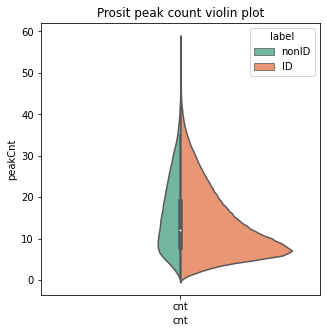

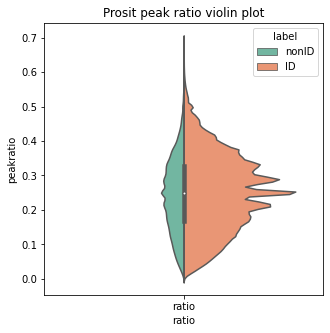

In [188]:
qual_viz(bad_p2qual010cnt, bad_p2qual010ratio, good_p2qual010cnt, good_p2qual010ratio)

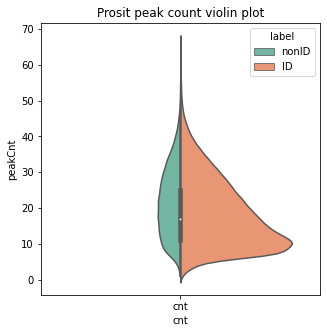

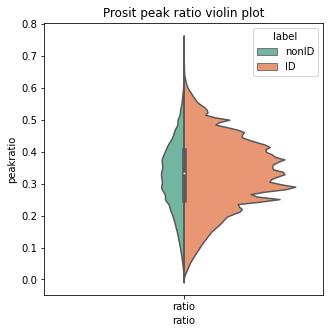

In [187]:
qual_viz(bad_p2qual005cnt, bad_p2qual005ratio, good_p2qual005cnt, good_p2qual005ratio)

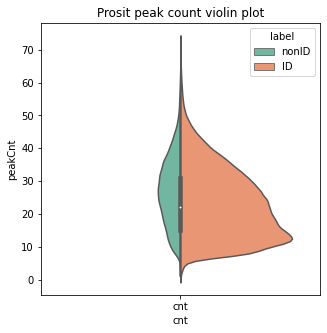

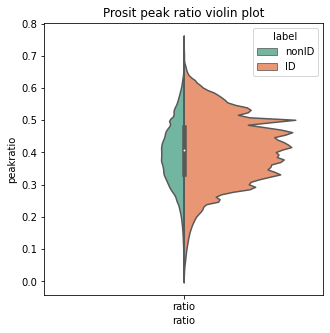

In [186]:
qual_viz(bad_p2qual002cnt, bad_p2qual002ratio, good_p2qual002cnt, good_p2qual002ratio)

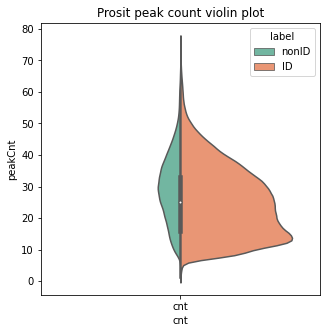

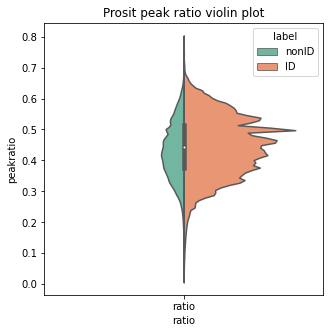

In [185]:
qual_viz(bad_p2qual001cnt, bad_p2qual001ratio, good_p2qual001cnt, good_p2qual001ratio)

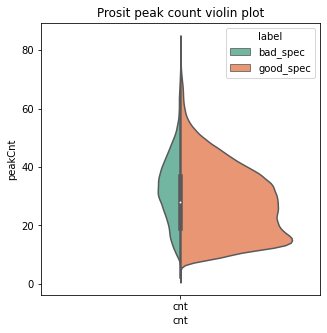

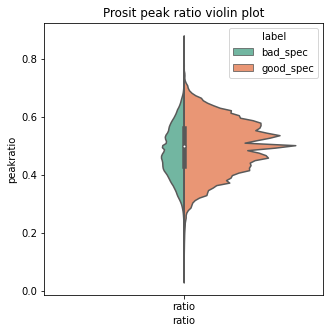

In [194]:
bc, br = spec2qual_thr(bad_spec, 0.001)
gc, gr = spec2qual_thr(good_spec, 0.001)
qual_viz(bc, br, gc, gr)

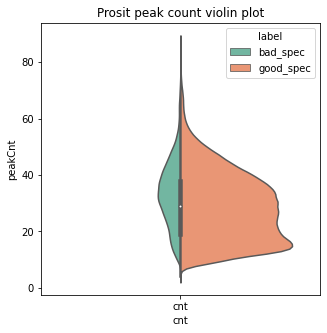

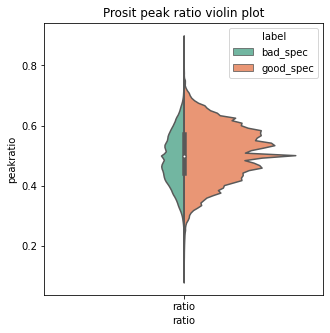

In [200]:
bc, br = spec2qual_thr(bad_spec, 0)
gc, gr = spec2qual_thr(good_spec, 0)
qual_viz(bc, br, gc, gr)

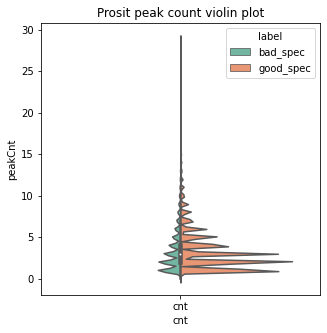

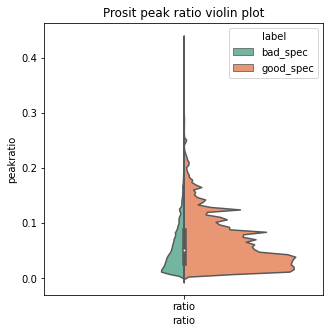

In [202]:
bc, br = spec2qual_thr(bad_spec, 0.5)
gc, gr = spec2qual_thr(good_spec, 0.5)
qual_viz(bc, br, gc, gr)

In [217]:
def spec_plot(mz, i, p):
    plt.figure(figsize=(14, 4))
    plt.bar(mz, i, color='gray')
    plt.title(p)
    plt.show()

In [ ]:
p2mz = dict()
p2int = dict()
for p, mz, i in good_spec[['PEP', 'MZ', 'INT']].values:
    mz = list(map(float, mz.split(';')))
    i = list(map(float, i.split(';')))
    p2mz[p] = mz
    p2int[p] = i

for m_, i_ in zip(p2mz.values(), p2int.values()):
    spec_plot(m_, i_)